In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Upload Dataset
from google.colab import files
uploaded = files.upload()

Saving Iot Data.csv to Iot Data.csv


In [2]:
df = pd.read_csv(list(uploaded.keys())[0])

print(df.shape)
display(df.head())
print(df.dtypes)
print(df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())
print("Sensors:", df["Sensors"].unique())

(32319, 6)


,TIME,Sensors,Water Temperature,pH,EC,DO
0,2022-08-10T02:02:56.000Z,1,26.1,8.3,0.66,5.1
1,2022-08-10T02:05:10.000Z,2,23.9,8.6,0.65,5.0
2,2022-08-10T02:07:59.000Z,1,25.9,8.3,0.67,5.2
3,2022-08-10T02:12:18.000Z,2,23.9,8.6,0.65,4.9
4,2022-08-10T02:13:01.000Z,1,25.7,8.3,0.67,5.1


TIME                  object
Sensors                int64
Water Temperature    float64
pH                   float64
EC                   float64
DO                   float64
dtype: object
TIME                 0
Sensors              0
Water Temperature    0
pH                   0
EC                   0
DO                   0
dtype: int64
Duplicate rows: 0
Sensors: [1 2]


In [3]:
df = df.copy()

# Parse TIME (it’s ISO-8601 with 'Z' -> UTC)
df["TIME"] = pd.to_datetime(df["TIME"], utc=True, errors="coerce")

# Rename columns to easier names
df = df.rename(columns={
    "TIME": "time",
    "Sensors": "sensor",
    "Water Temperature": "water_temp",
    "pH": "ph",
    "EC": "ec",
    "DO": "do"
})

# Ensure numeric (defensive)
for col in ["water_temp","ph","ec","do"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with bad timestamps (should be none, but safe)
df = df.dropna(subset=["time"])

# Sort
df = df.sort_values(["sensor","time"]).reset_index(drop=True)

display(df.head())
print(df.isna().sum())


,time,sensor,water_temp,ph,ec,do
0,2022-08-10 02:02:56+00:00,1,26.1,8.3,0.66,5.1
1,2022-08-10 02:07:59+00:00,1,25.9,8.3,0.67,5.2
2,2022-08-10 02:13:01+00:00,1,25.7,8.3,0.67,5.1
3,2022-08-10 02:18:03+00:00,1,25.3,8.2,0.68,5.3
4,2022-08-10 02:23:05+00:00,1,24.8,8.2,0.68,5.3


time          0
sensor        0
water_temp    0
ph            0
ec            0
do            0
dtype: int64


In [4]:
df = df.copy()

# Replace exact zeros (only for columns where 0 is suspicious)
for col in ["ph", "ec", "do"]:
    df.loc[df[col] == 0, col] = np.nan

# Forward-fill within each sensor stream
df[["ph","ec","do","water_temp"]] = (
    df.groupby("sensor")[["ph","ec","do","water_temp"]]
      .apply(lambda g: g.ffill())
      .reset_index(level=0, drop=True)
)

print(df.isna().sum())


time          0
sensor        0
water_temp    0
ph            0
ec            0
do            0
dtype: int64


In [12]:
df = df.sort_values(["sensor","time"]).reset_index(drop=True)

# time step between consecutive readings within each sensor stream
df["dt_seconds"] = df.groupby("sensor")["time"].diff().dt.total_seconds()

# "segment" increments whenever there's a big gap (prevents features leaking across outages)
# 600s = 10 minutes (2x expected 5-min interval).can adjust if needed.
df["segment"] = (df["dt_seconds"] > 600).groupby(df["sensor"]).cumsum()

# Inspect big gaps (> 1 hour)
gaps = df[df["dt_seconds"] > 3600][["sensor","time","dt_seconds","segment"]]
print("Big gaps:", len(gaps))
display(gaps.head(10))


Big gaps: 55


,sensor,time,dt_seconds,segment
12249,1,2022-09-28 10:44:58+00:00,556324.0,12
12394,1,2022-11-04 18:20:00+00:00,3194627.0,13
14884,1,2022-11-15 23:34:21+00:00,15950.0,283
14910,1,2022-11-16 20:21:13+00:00,58108.0,292
14913,1,2022-11-16 23:11:01+00:00,6238.0,295
14939,1,2022-11-17 11:59:32+00:00,19722.0,308
14940,1,2022-11-17 13:29:58+00:00,5426.0,309
14944,1,2022-11-17 22:06:03+00:00,26007.0,313
14945,1,2022-11-17 23:27:46+00:00,4903.0,314
14957,1,2022-11-18 03:36:34+00:00,5560.0,322


In [13]:
df = df.copy()

for col in ["ph", "ec", "do"]:
    df.loc[df[col] == 0, col] = np.nan


In [14]:
cols = ["water_temp","ph","ec","do"]

# Fill short dropouts only (limit prevents filling across long outages)
df[cols] = (
    df.groupby("sensor")[cols]
      .apply(lambda g: g.ffill(limit=12))   # 12*5min ≈ 1 hour
      .reset_index(level=0, drop=True)
)

print(df[cols].isna().sum())


water_temp    0
ph            0
ec            0
do            0
dtype: int64


water_temp                                                          ph  \
            count       mean       std   min   25%   50%   75%   max    count   
sensor                                                                          
1         16161.0  20.618402  2.887585  13.6  18.4  19.5  23.0  29.1  16161.0   
2         16158.0  19.730746  2.120888  15.5  18.2  19.1  21.8  25.0  16158.0   

                  ...    ec             do                                     \
            mean  ...   75%   max    count      mean       std  min  25%  50%   
sensor            ...                                                           
1       6.160510  ...  2.67  7.43  16161.0  5.412895  2.861360  0.4  3.5  4.7   
2       6.528574  ...  2.21  3.81  16158.0  1.996194  4.718066  0.1  0.4  0.8   

                   
        75%   max  
sensor             
1       7.0  48.0  
2       2.2  30.0  

[2 rows x 32 columns]

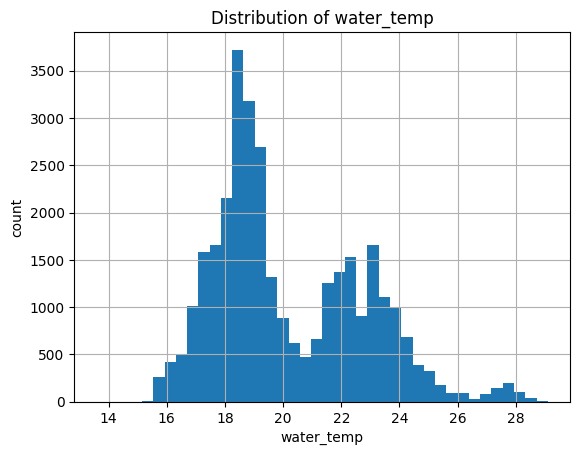

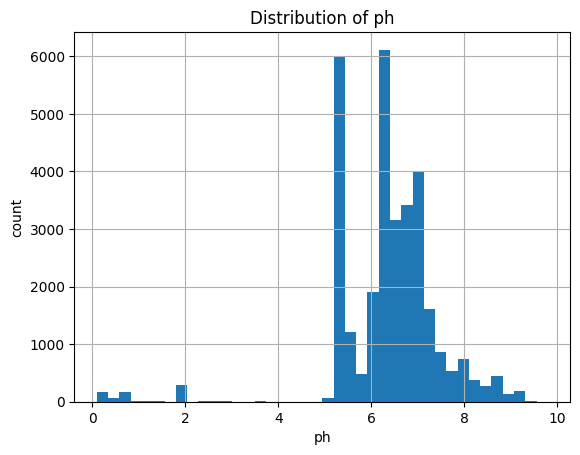

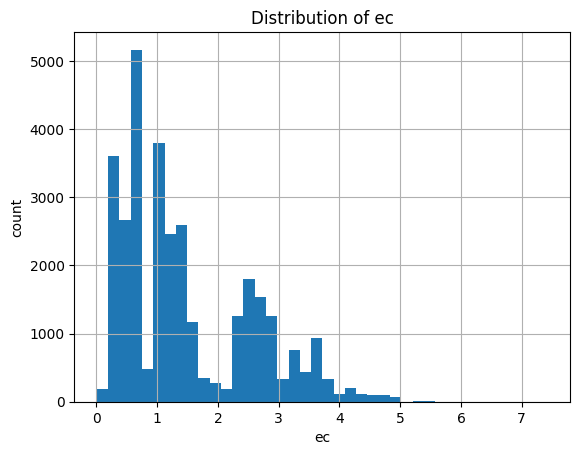

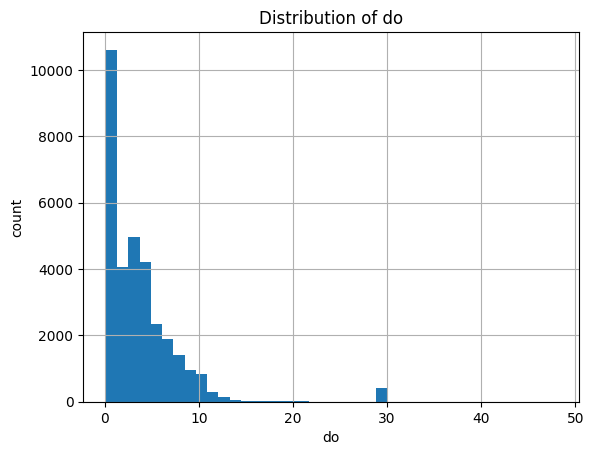

In [6]:
display(df.groupby("sensor")[["water_temp","ph","ec","do"]].describe())

# Histograms
cols = ["water_temp","ph","ec","do"]
for c in cols:
    plt.figure()
    df[c].hist(bins=40)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()


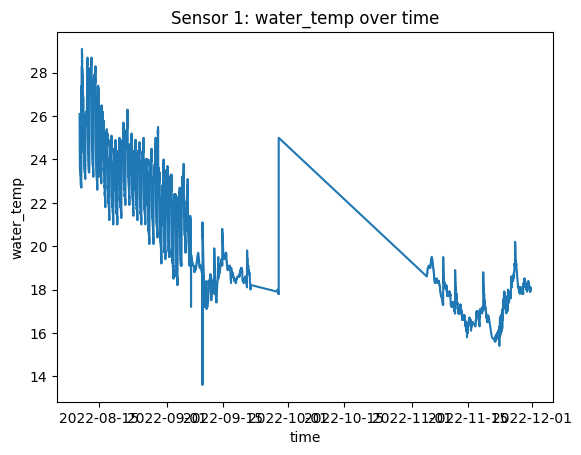

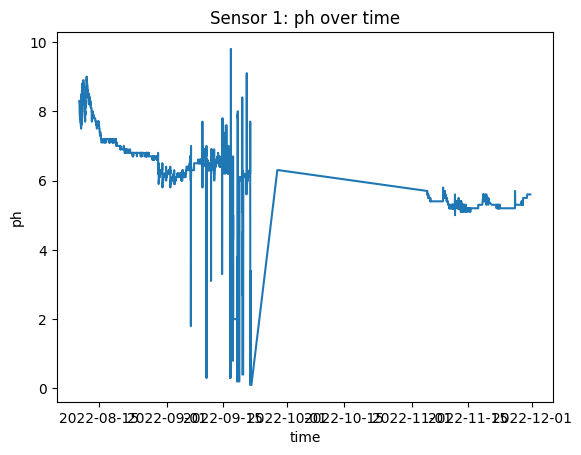

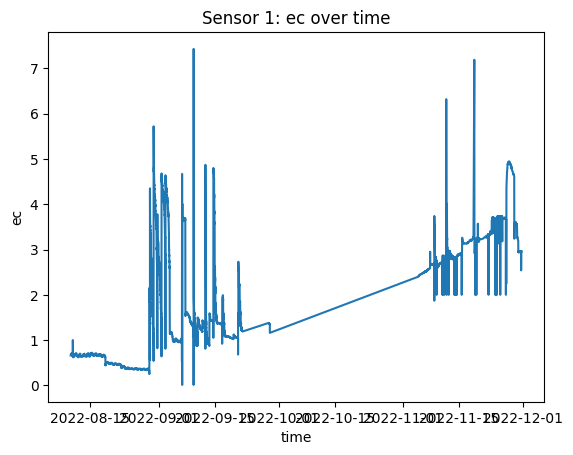

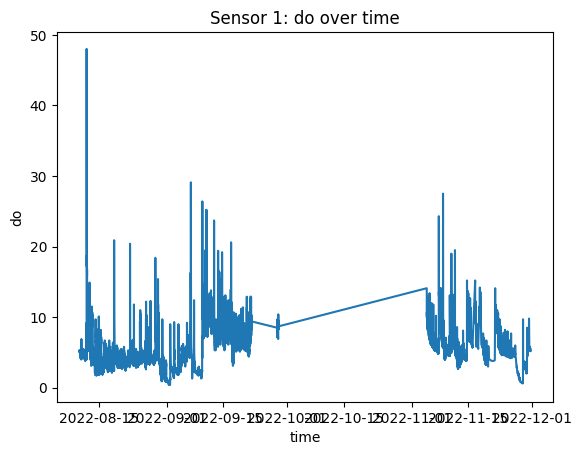

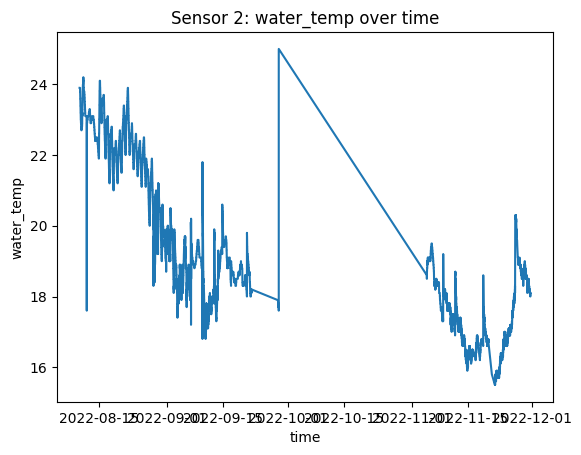

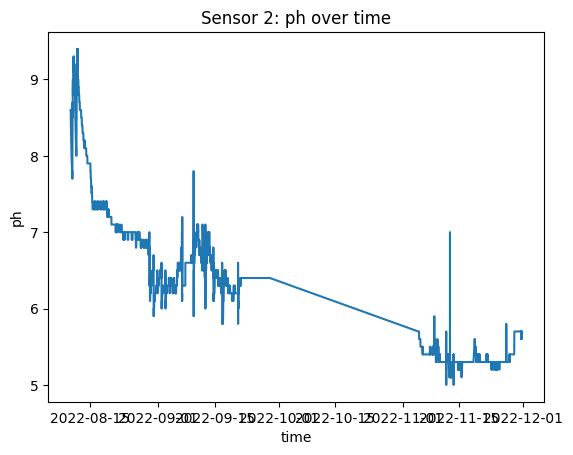

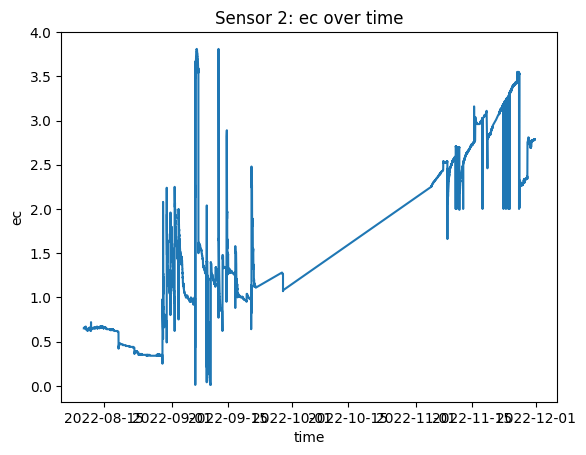

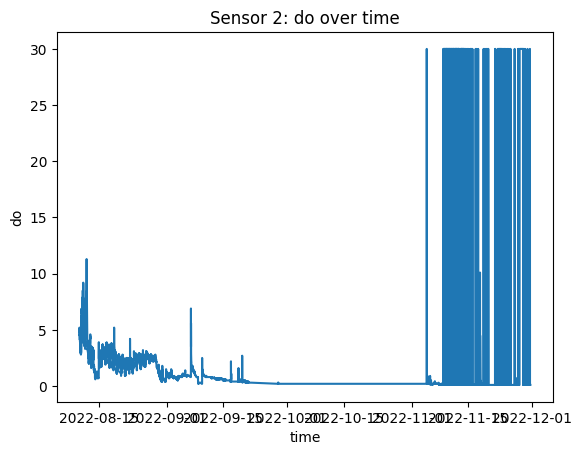

In [7]:
for sensor_id, g in df.groupby("sensor"):
    g = g.sort_values("time")
    for c in ["water_temp","ph","ec","do"]:
        plt.figure()
        plt.plot(g["time"], g[c])
        plt.title(f"Sensor {sensor_id}: {c} over time")
        plt.xlabel("time")
        plt.ylabel(c)
        plt.show()


In [8]:
df_ts = df.set_index("time")

resampled = (df_ts.groupby("sensor")[["water_temp","ph","ec","do"]]
                  .resample("5min")
                  .mean()
                  .reset_index())

display(resampled.head())


,sensor,time,water_temp,ph,ec,do
0,1,2022-08-10 02:00:00+00:00,26.1,8.3,0.66,5.1
1,1,2022-08-10 02:05:00+00:00,25.9,8.3,0.67,5.2
2,1,2022-08-10 02:10:00+00:00,25.7,8.3,0.67,5.1
3,1,2022-08-10 02:15:00+00:00,25.3,8.2,0.68,5.3
4,1,2022-08-10 02:20:00+00:00,24.8,8.2,0.68,5.3


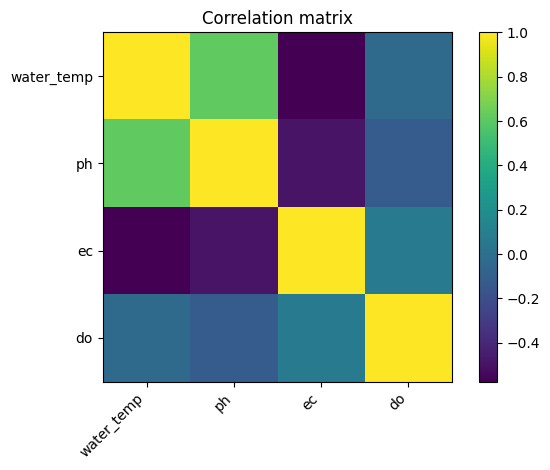

,water_temp,ph,ec,do
water_temp,1.000000,0.612872,-0.574902,-0.027437
ph,0.612872,1.000000,-0.493857,-0.118723
ec,-0.574902,-0.493857,1.000000,0.077790
do,-0.027437,-0.118723,0.077790,1.000000


In [9]:
# Overall correlation
corr = df[["water_temp","ph","ec","do"]].corr()

plt.figure()
plt.imshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

display(corr)


In [10]:
for sensor_id, g in df.groupby("sensor"):
    corr = g[["water_temp","ph","ec","do"]].corr()
    print(f"\nSensor {sensor_id} correlation:")
    display(corr)



Sensor 1 correlation:


,water_temp,ph,ec,do
water_temp,1.000000,0.587307,-0.568757,-0.295846
ph,0.587307,1.000000,-0.344864,-0.145002
ec,-0.568757,-0.344864,1.000000,-0.027078
do,-0.295846,-0.145002,-0.027078,1.000000



Sensor 2 correlation:


,water_temp,ph,ec,do
water_temp,1.000000,0.814847,-0.699342,0.032678
ph,0.814847,1.000000,-0.771312,0.005025
ec,-0.699342,-0.771312,1.000000,0.063686
do,0.032678,0.005025,0.063686,1.000000


In [11]:
df_feat = df.copy()
df_feat["hour"] = df_feat["time"].dt.hour
df_feat["dayofweek"] = df_feat["time"].dt.dayofweek
df_feat["month"] = df_feat["time"].dt.month

# Rolling stats (per sensor)
df_feat = df_feat.sort_values(["sensor","time"])
for c in ["water_temp","ph","ec","do"]:
    df_feat[f"{c}_roll_mean_1h"] = (
        df_feat.groupby("sensor")[c].transform(lambda s: s.rolling(12, min_periods=3).mean())
    )

display(df_feat.head())


,time,sensor,water_temp,ph,ec,do,dt_seconds,hour,dayofweek,month,water_temp_roll_mean_1h,ph_roll_mean_1h,ec_roll_mean_1h,do_roll_mean_1h
0,2022-08-10 02:02:56+00:00,1,26.1,8.3,0.66,5.1,NaN,2,2,8,NaN,NaN,NaN,NaN
1,2022-08-10 02:07:59+00:00,1,25.9,8.3,0.67,5.2,303.0,2,2,8,NaN,NaN,NaN,NaN
2,2022-08-10 02:13:01+00:00,1,25.7,8.3,0.67,5.1,302.0,2,2,8,25.90,8.300,0.666667,5.133333
3,2022-08-10 02:18:03+00:00,1,25.3,8.2,0.68,5.3,302.0,2,2,8,25.75,8.275,0.670000,5.175000
4,2022-08-10 02:23:05+00:00,1,24.8,8.2,0.68,5.3,302.0,2,2,8,25.56,8.260,0.672000,5.200000
